In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore')
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' # 나눔 고딕
font_name = fm.FontProperties(fname=path, size=10).get_name() # 기본 폰트 사이즈 : 10
plt.rc('font', family=font_name)

In [ ]:
original_data=pd.read_csv('/content/drive/MyDrive/skt/WEEK1/digital/1 일반국민_raw data.csv')

In [ ]:
data=original_data.iloc[:,np.r_[227,208:220]].copy()
dlq=np.arange(1,13)

In [ ]:
data.isnull().sum().sum()

0

In [ ]:
data.rename(columns={'ADQ1':'age'},inplace=True)

In [ ]:
data['ai']=original_data['Q21']%2

In [ ]:
data=data.join(original_data.iloc[:,149:168])
ainq=np.arange(14,22)
aiq=np.arange(22,33)

In [ ]:
data['dln']=data.iloc[:,dlq].sum(axis=1)
data['dl']=['low' if x < 24 else ('middle' if x < 48 else 'high') for x in data['dln']]

In [ ]:
data['agec']=['청소년' if x < 20 else ('청년' if x < 40 else ('중년' if x<60 else '노년')) for x in data['age']]

In [ ]:
X=data['age']
y=data['dln']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11
)

In [ ]:
# def prescoring(X, y):
#     scoring = {
#         'MSE': 'neg_mean_squared_error',
#         'MAE': 'neg_mean_absolute_error',
#         'R2': 'r2'
#     }
#     models = {
#         'Ridge': Ridge(),
#         'Lasso': Lasso(),
#         'ElasticNet': ElasticNet()
#     }
#     score = {model_name: {} for model_name in models.keys()}

#     for model_name, model in models.items():
#         for sc_name, sc in scoring.items():
#             cv_score = cross_val_score(model, X.values.reshape(-1,1), y.values.reshape(-1,1), scoring=sc, cv=5)
#             score[model_name][sc_name] = np.round(np.mean(np.abs(cv_score)), 4)
#     score_df = pd.DataFrame(score)
#     return score_df

# prescoring(X,y)

In [ ]:
def linear_reg(model_name=None, X_train=None, y_train=None, X_test=None, l1_rate=0.5, alp=1):
  if model_name is None or X_train is None or y_train is None:
    raise ValueError("essential parameter is None")
  if model_name=='Ridge': model = Ridge(alpha=alp)
  elif model_name=='Lasso': model = Lasso(alpha=alp)
  elif model_name=='ElasticNet': model = ElasticNet(alpha=alp, l1_ratio=l1_rate)
  else: raise ValueError("model_name err")
  model.fit(X_train,y_train)
  pred=None
  if X_test is not None : pred=model.predict(X_test)
  w=[model.coef_,model.intercept_]
  return w, pred

In [ ]:
def plot_1(X,y,w):
  plt.scatter(X,y)
  plt.plot(X,w[0]*X+w[1], color='black')
  plt.show()

In [ ]:
w,pred=linear_reg(model_name='Ridge',X_train=X_train.values.reshape(-1,1),
                  y_train=y_train, X_test=X_test.values.reshape(-1,1))
r2=r2_score(y_test,pred)
mse=mean_squared_error(y_test,pred)
mae=mean_absolute_error(y_test,pred)

나이와 디지털 리터러시

가설: 나이가 증가함에 따라 디지털 역량은 감소한다

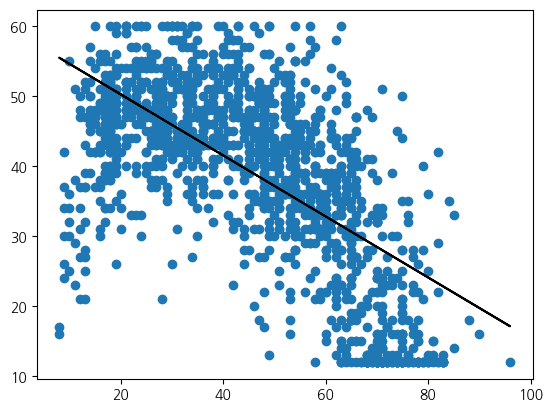

mse: 99.3172873938999 mae: 7.892831250160147 r2: 0.40780523495824395


In [ ]:
plot_1(X_test,y_test,w)
print('mse:',mse,'mae:',mae , 'r2:',r2)

어느정도의 경향성은 보여주지만


1 약 20세 까지는 나이가 증가함에 따라 디지털 리터러시도 증가함   ->  다중선형회귀 or 20세 이하 제거


2 같은 나이라도 편차가 큼   ->  다른 feature 추가


20세 이하를 제외해 보았음

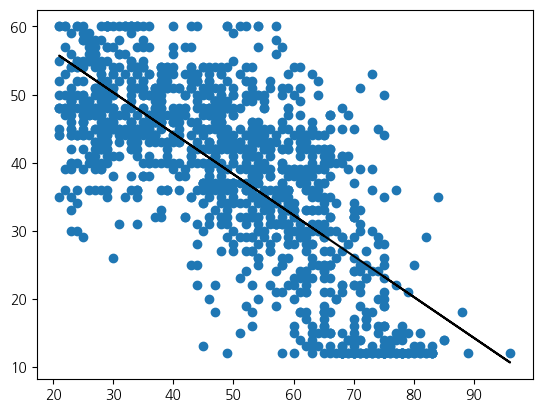

mse: 84.13789899754265 mae: 7.424581231923722 r2: 0.4978103263839293


In [ ]:
X1=data.loc[data['age'] > 20, 'age']
y1 = data.loc[data['age'] > 20, 'dln']
X_train, X_test, y_train, y_test = train_test_split(
    X1, y1, test_size=0.2, random_state=11
)
w,pred=linear_reg(model_name='Ridge',X_train=X_train.values.reshape(-1,1),
                  y_train=y_train, X_test=X_test.values.reshape(-1,1))
r2=r2_score(y_test,pred)
mse=mean_squared_error(y_test,pred)
mae=mean_absolute_error(y_test,pred)
plot_1(X_test,y_test,w)
print('mse:',mse,'mae:',mae , 'r2:',r2)

오차 소폭 감소

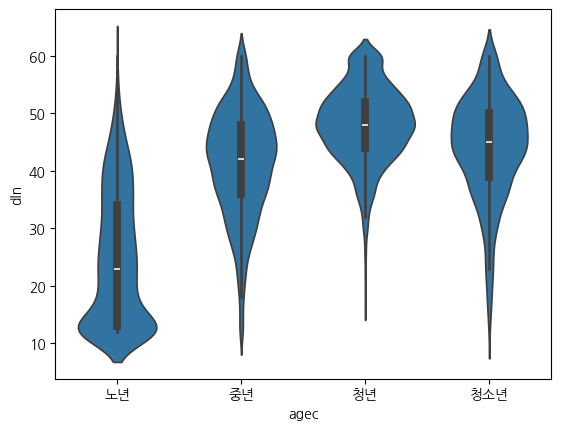

In [ ]:
sns.violinplot(x='agec', y='dln', data=data)
plt.show()

violin plot으로 나타내니 경향이 더 잘 보임

나이와 ai사용률 plot

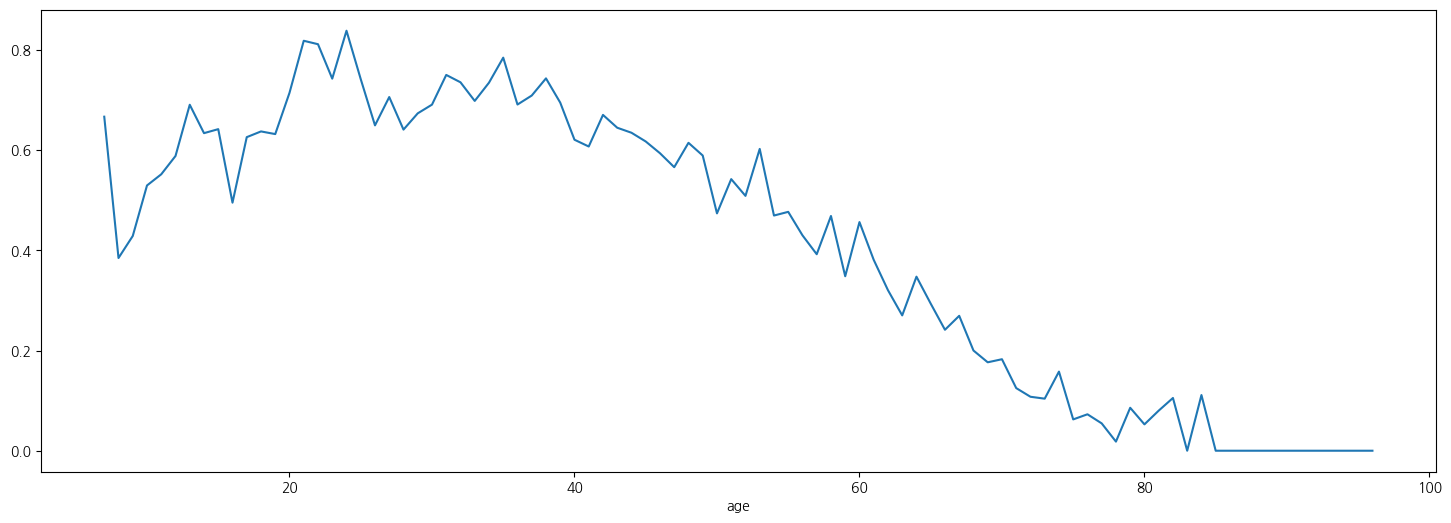

In [ ]:
ai_usage_age = data.groupby('age')['ai'].mean()
plt.figure(figsize=(18, 6))
ai_usage_age.plot()
plt.show()

2,30대에서 가장 높고 멀어질수록 감소함

디지털 리터러시와 ai사용률

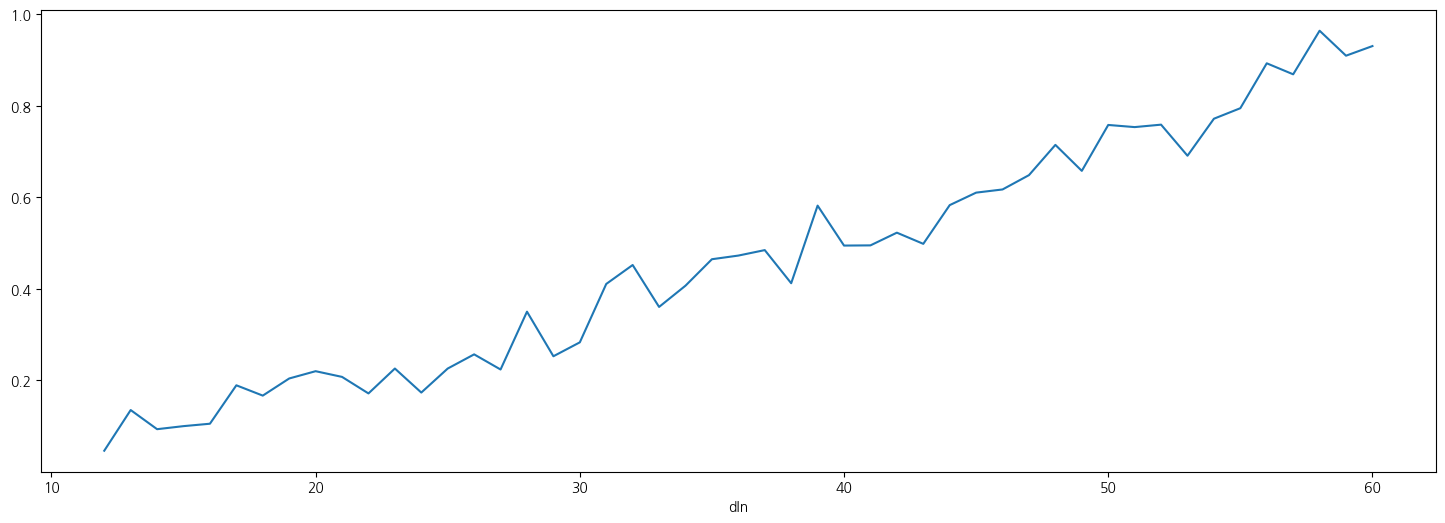

In [ ]:
ai_usage_dl = data.groupby('dln')['ai'].mean()
plt.figure(figsize=(18, 6))
ai_usage_dl.plot()
plt.show()

비례하는 경향

예측모델 그려봄

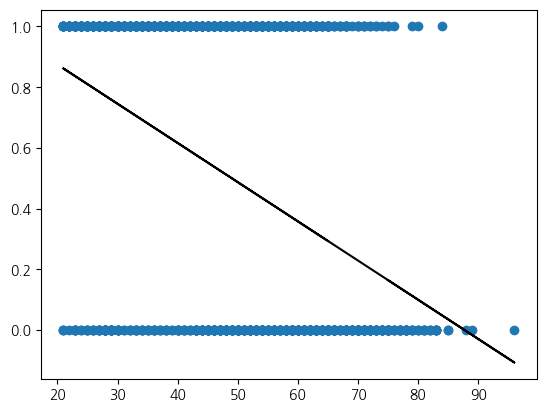

mse: 0.20380973877557765 mae: 0.4111580009097534 r2: 0.18275819762198608


In [ ]:
X=data.loc[data['age'] > 20, 'age']
y = data.loc[data['age'] > 20, 'ai']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11
)
w,pred=linear_reg(model_name='Ridge',X_train=X_train.values.reshape(-1,1),
                  y_train=y_train, X_test=X_test.values.reshape(-1,1))
r2=r2_score(y_test,pred)
mse=mean_squared_error(y_test,pred)
mae=mean_absolute_error(y_test,pred)
plot_1(X_test,y_test,w)
print('mse:',mse,'mae:',mae , 'r2:',r2)

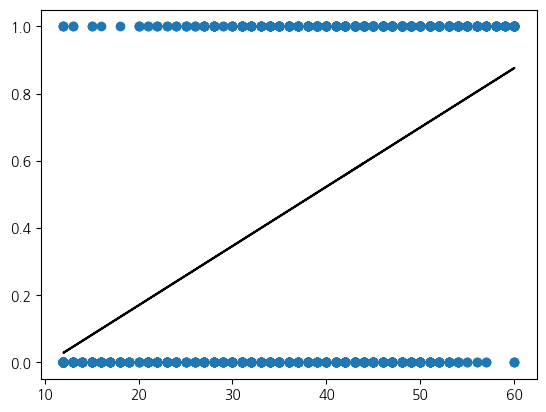

mse: 0.18907504365204703 mae: 0.38676235311233315 r2: 0.2421160025072554


In [ ]:
X=data['dln']
y=data['ai']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11
)
w,pred=linear_reg(model_name='Ridge',X_train=X_train.values.reshape(-1,1),
                  y_train=y_train, X_test=X_test.values.reshape(-1,1))
r2=r2_score(y_test,pred)
mse=mean_squared_error(y_test,pred)
mae=mean_absolute_error(y_test,pred)
plot_1(X_test,y_test,w)
print('mse:',mse,'mae:',mae , 'r2:',r2)

범주형 데이터라 그런지 좋지 않은 결과

나이와 디지털 리터러시 둘 모두 사용해서 예측모델 그려봄

In [ ]:
X1=data.loc[data['age'] > 20, ['age','dln']]
y1 = data.loc[data['age'] > 20, 'ai']
X_train, X_test, y_train, y_test = train_test_split(
    X1, y1, test_size=0.2, random_state=11
)


In [ ]:
def plot_2(X, y,w):

  XX=X.values
  yy=y.values
  XX=np.array(XX)
  yy=np.array(yy)


  plt.scatter(XX[yy==1, 0], XX[yy==1, 1], color='blue', label='yes')
  plt.scatter(XX[yy==0, 0], XX[yy==0, 1], color='red', label='no')


  plt.xlabel('age')
  plt.ylabel('Digital Literacy')
  plt.legend()
  plt.show()

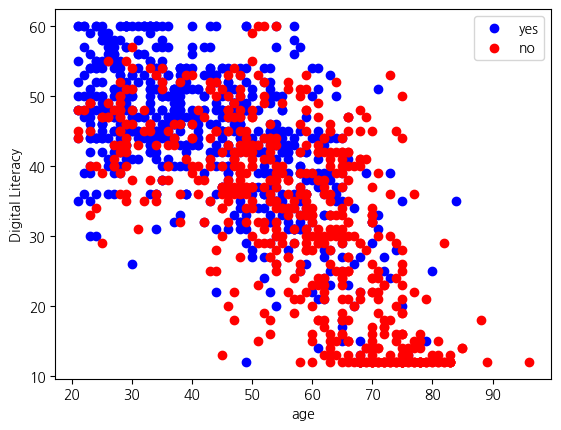

mse: 0.19251900090341678 mae: 0.3851459614266476 r2: 0.2280321036887758


In [ ]:
w,pred=linear_reg(model_name='Ridge',X_train=X_train,
                  y_train=y_train, X_test=X_test)
r2=r2_score(y_test,pred)
mse=mean_squared_error(y_test,pred)
mae=mean_absolute_error(y_test,pred)
plot_2(X_test,y_test,w)
print('mse:',mse,'mae:',mae , 'r2:',r2)

상관관계 분석

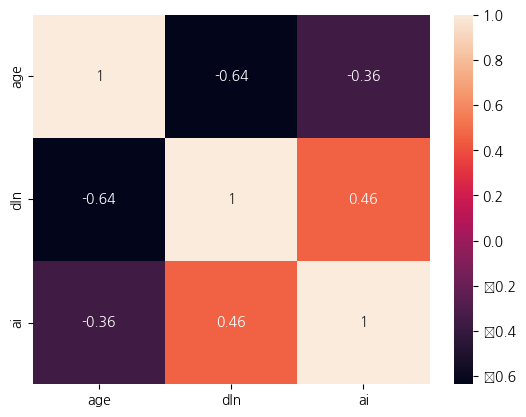

In [ ]:
corr=data[['age','dln','ai']].corr()
corr
sns.heatmap(corr,annot=True)
plt.show()

나이와 디지털 리터러시가 가장 연관됨

나이별, 디지털역량별로 ai를 사용하지 않는 이유가 다를 것 같음

가설

1\. 나이대가 올라갈 수록 '아직 AI에 대해 잘 몰라서', '이용 방법이 어려워서' 등 사용 난이도에 의한 비중이 증가할 것이다

2\. 디지털 역량이 높으면 '이용할 기기/제품이 없어서', '이용할 필요성이 없어서'등 필요성에 의한 비중이 올라갈 것이다

사용하지 않는 이유

-가격/요금이 비싸서

-아직 AI에 대해 잘 몰라서

-이용할 기기/제품이 없어서

-이용할 필요성이 없어서

-이용방법이 어려워서

-기술에 대한 거부감이 있어서

-신체적 제약으로 이용이 어려워서

-기타


디지털 리터러시는 \~23점, 24\~48점, 49\~로 분류

나이는 \~20세, 20\~40세, 40\~60세, 60\~로 분류

In [ ]:
not_ai_data=data.loc[data['ai']==0]

In [ ]:
reason=[
    '가격/요금이 비싸서',
    '아직 AI에 대해 잘 몰라서',
    '이용할 기기/제품이 없어서',
    '이용할 필요성이 없어서',
    '이용방법이 어려워서',
    '기술에 대한 거부감이 있어서',
    '신체적 제약으로 이용이 어려워서',
    '기타'
]

In [ ]:
agec=['청소년','청년','중년','노년']
dl=['low','middle','high' ]

In [ ]:
reasons = [ 'Q23A1', 'Q23A2', 'Q23A3', 'Q23A4', 'Q23A5', 'Q23A6', 'Q23A7', 'Q23A8']

In [ ]:
reasons_count_age=np.zeros([4,8])
for i in range(4):
  for j in range(8):
    reasons_count_age[i,j]=((not_ai_data[reasons[j]]!=' ') & (not_ai_data['agec']==agec[i])).sum()



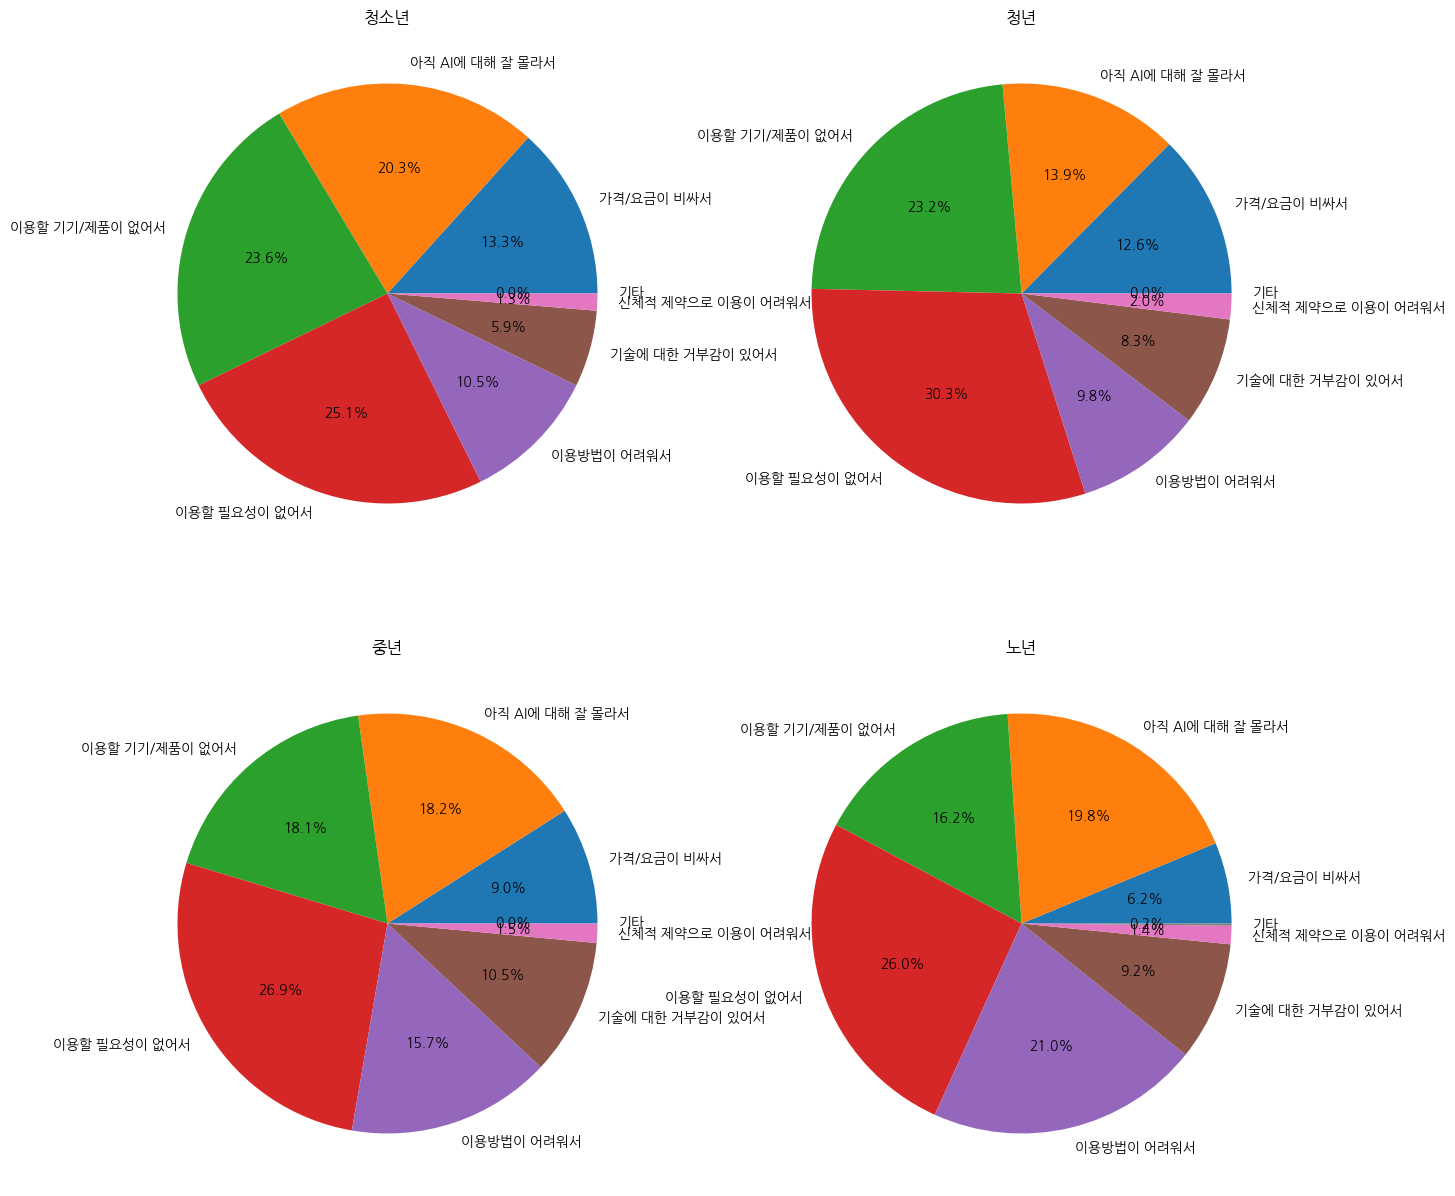

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for i, ax in enumerate(axs.flatten()):
  title=agec[i]
  ax.pie(reasons_count_age[i], labels=reason, autopct='%1.1f%%')
  ax.set_title(title)
plt.show()



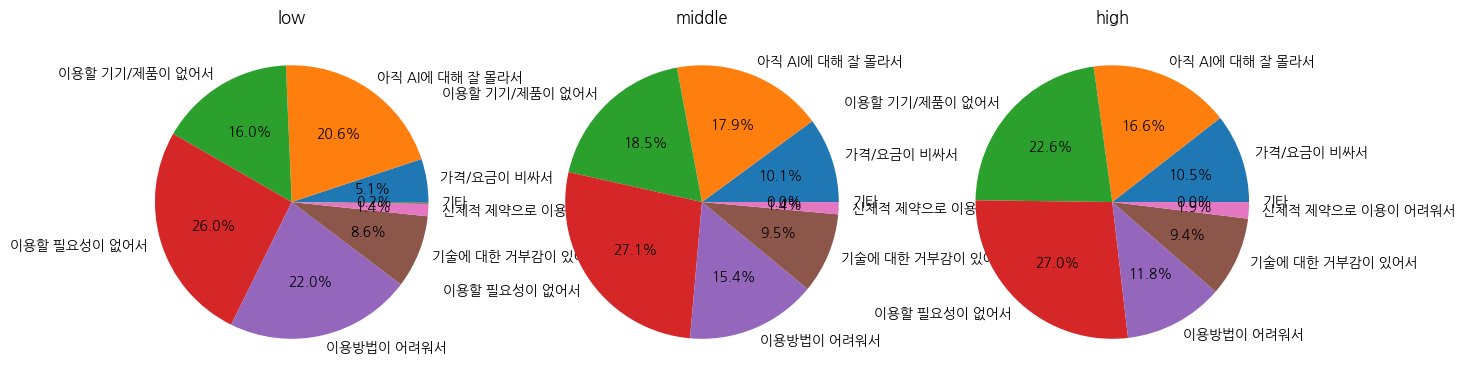

In [ ]:
reasons_count_dl=np.zeros([3,8])
for i in range(3):
  for j in range(8):
    reasons_count_dl[i,j]=((not_ai_data[reasons[j]]!=' ') & (not_ai_data['dl']==dl[i])).sum()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axs.flatten()):
  title=dl[i]
  ax.pie(reasons_count_dl[i], labels=reason, autopct='%1.1f%%')
  ax.set_title(title)
plt.show()


42%, 45.6%, 49.6%로 디지털 역량이 증가함에 따라 유의미하게 비중이 증가했다

## 직업별 디지털 역량 합산 순위

In [ ]:
# ADQ3의 숫자를 값으로 매핑
df_selected_cleaned['ADQ3'] = df_selected_cleaned['ADQ3'].map({
    1: '관리자',
    2: '전문가 및 관련 종사자',
    3: '사무 종사자',
    4: '서비스 종사자',
    5: '판매 종사자',
    6: '농립어업 숙련 종사자',
    7: '기능원 및 관련 기능 종사자',
    8: '장치/기계조작 및 조립 종사자',
    9: '단순노무 종사자',
    10: '군인',
    11: '전업주부',
    12: '초/중/고등학생',
    13: '대학생',
    14: '무직',
    15: '기타'
})

# 결과 확인
df_selected_cleaned['ADQ3'].value_counts()

ADQ3
사무 종사자              1243
서비스 종사자             1106
전업주부                 930
판매 종사자               871
초/중/고등학생             768
기능원 및 관련 기능 종사자      388
대학생                  387
무직                   350
단순노무 종사자             244
농립어업 숙련 종사자          241
전문가 및 관련 종사자         192
장치/기계조작 및 조립 종사자     139
관리자                   93
기타                    42
군인                     6
Name: count, dtype: int64

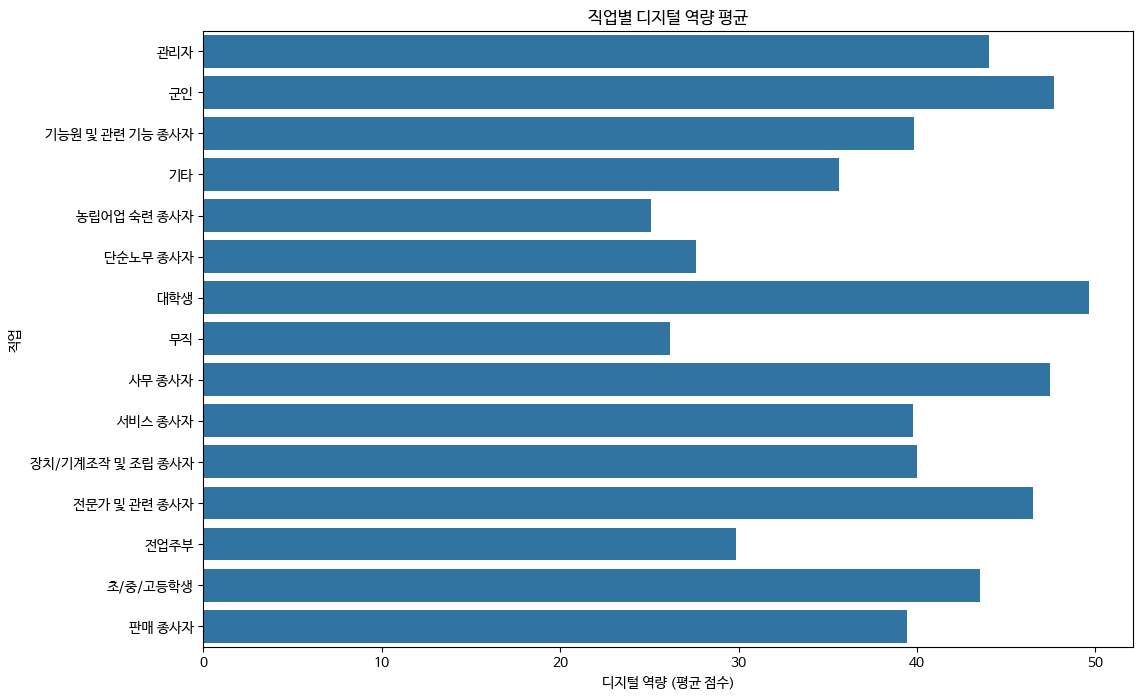

In [ ]:
# 직업별 디지털 역량 평균 계산
grouped = df_selected_cleaned.groupby('ADQ3').agg({'digital_skill': 'mean'}).reset_index()

# 히스토그램 그리기 (바 차트)
plt.figure(figsize=(12, 8))
sns.barplot(data=grouped, x='digital_skill', y='ADQ3')
plt.title('직업별 디지털 역량 평균')
plt.xlabel('디지털 역량 (평균 점수)')
plt.ylabel('직업')
plt.show()

=> 대학생, 군인, 사무종사자, 전문가 및 관련 종사자, 관리자, 초/중/고등학생 <br>
수업을 통해 쉽게 디지털을 접하는 학생들 <br>
근무 환경에서 디지털을 접하는 사무종사자, 전문가 및 관련 종사자, 군인 <br>

두 그룹으로 특징을 분류할 수 있음


## 직업별 인공지능 사용 여부

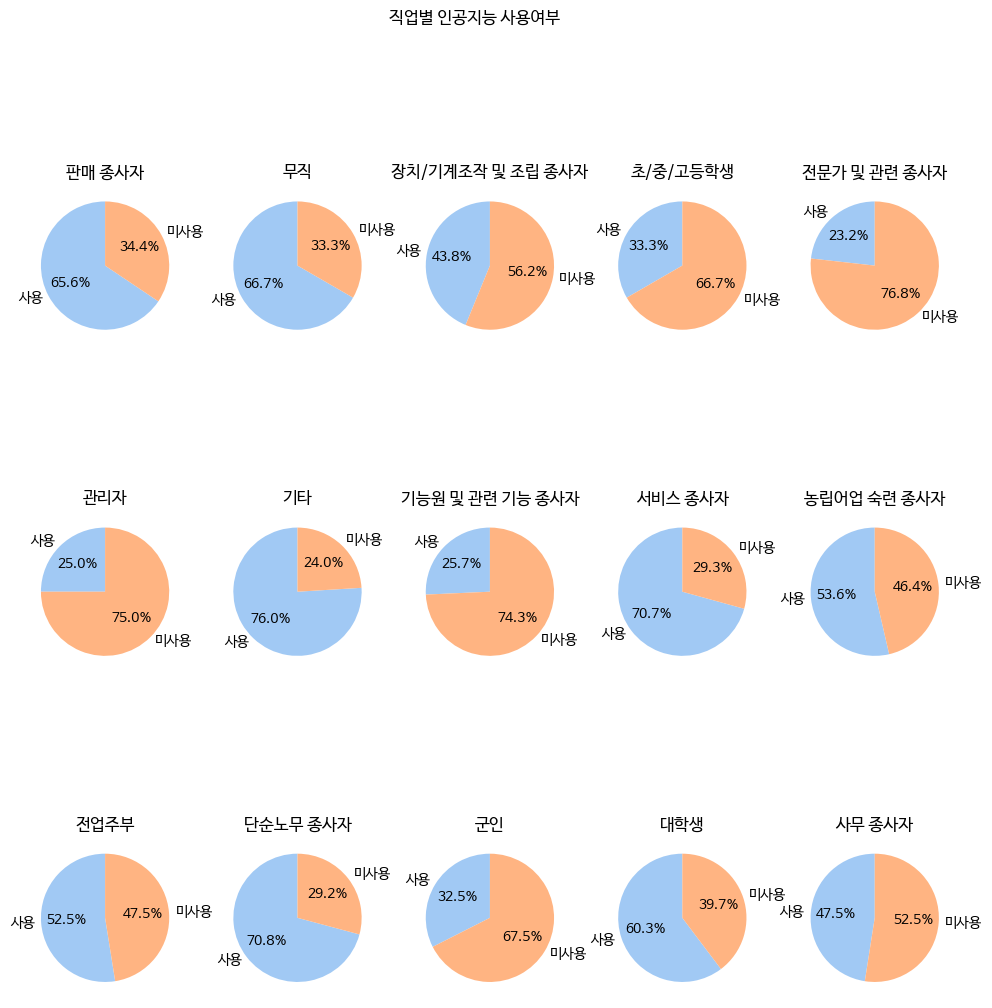

In [ ]:
# 직업별 인공지능 사용여부 비율 계산
ai_use = df_selected_cleaned.groupby(['ADQ3', 'Q21']).size().unstack(fill_value=0)

fig, axs = plt.subplots(3, 5, figsize=(12, 12))

# 직업별 데이터 준비
types = ai_use.index
titles = list(set(df_selected_cleaned['ADQ3']))
colors = sns.color_palette('pastel')[0:2]

for i, ax in enumerate(axs.flatten()):
    if i < len(types):
        data = ai_use.loc[types[i]]
        ax.pie(data, labels=['사용', '미사용'], autopct='%1.1f%%', colors=colors, startangle=90)
        ax.set_title(titles[i])

plt.suptitle('직업별 인공지능 사용여부')
plt.show()

- 사용함 <br>
판매 종사자, 무직, 서비스 종사자, 농립어업 숙련 종사자, 전업주부, 단순노무 종사자, 대학생
- 사용안함 <br>
장치/기계조작 및 조립 종사자, 초/중/고등학생, 전문가 및 관련 종사자, 관리자, 기능원 및 관련 기능 종사자, 군인, 사무 종사자


디지털 역량이 높다고 평가된 군인, 사무종사자, 전문가 및 관련 종사자, 관리자, 초/중/고등학생의 경우 디지털 역량은 높지만 그에 비해 인공지능 사용비율이 낮은 것을 확인할 수 있음

## 인공지능을 사용하지 않는다고 설문한 각 직업별 사용하지 않는 이유

In [ ]:
# 인공지능을 사용하지 않는 사람들 필터링
df_no_ai_use = df_selected_cleaned[df_selected_cleaned['Q21'] == 2]  # Q21이 2이면 인공지능을 사용하지 않는 것

df_no_ai_use['ADQ3'].value_counts()

ADQ3
전업주부                628
서비스 종사자             513
판매 종사자              457
사무 종사자              364
초/중/고등학생            305
무직                  260
기능원 및 관련 기능 종사자     218
농립어업 숙련 종사자         185
단순노무 종사자            183
대학생                  93
장치/기계조작 및 조립 종사자     66
전문가 및 관련 종사자         56
관리자                  32
기타                   28
군인                    2
Name: count, dtype: int64

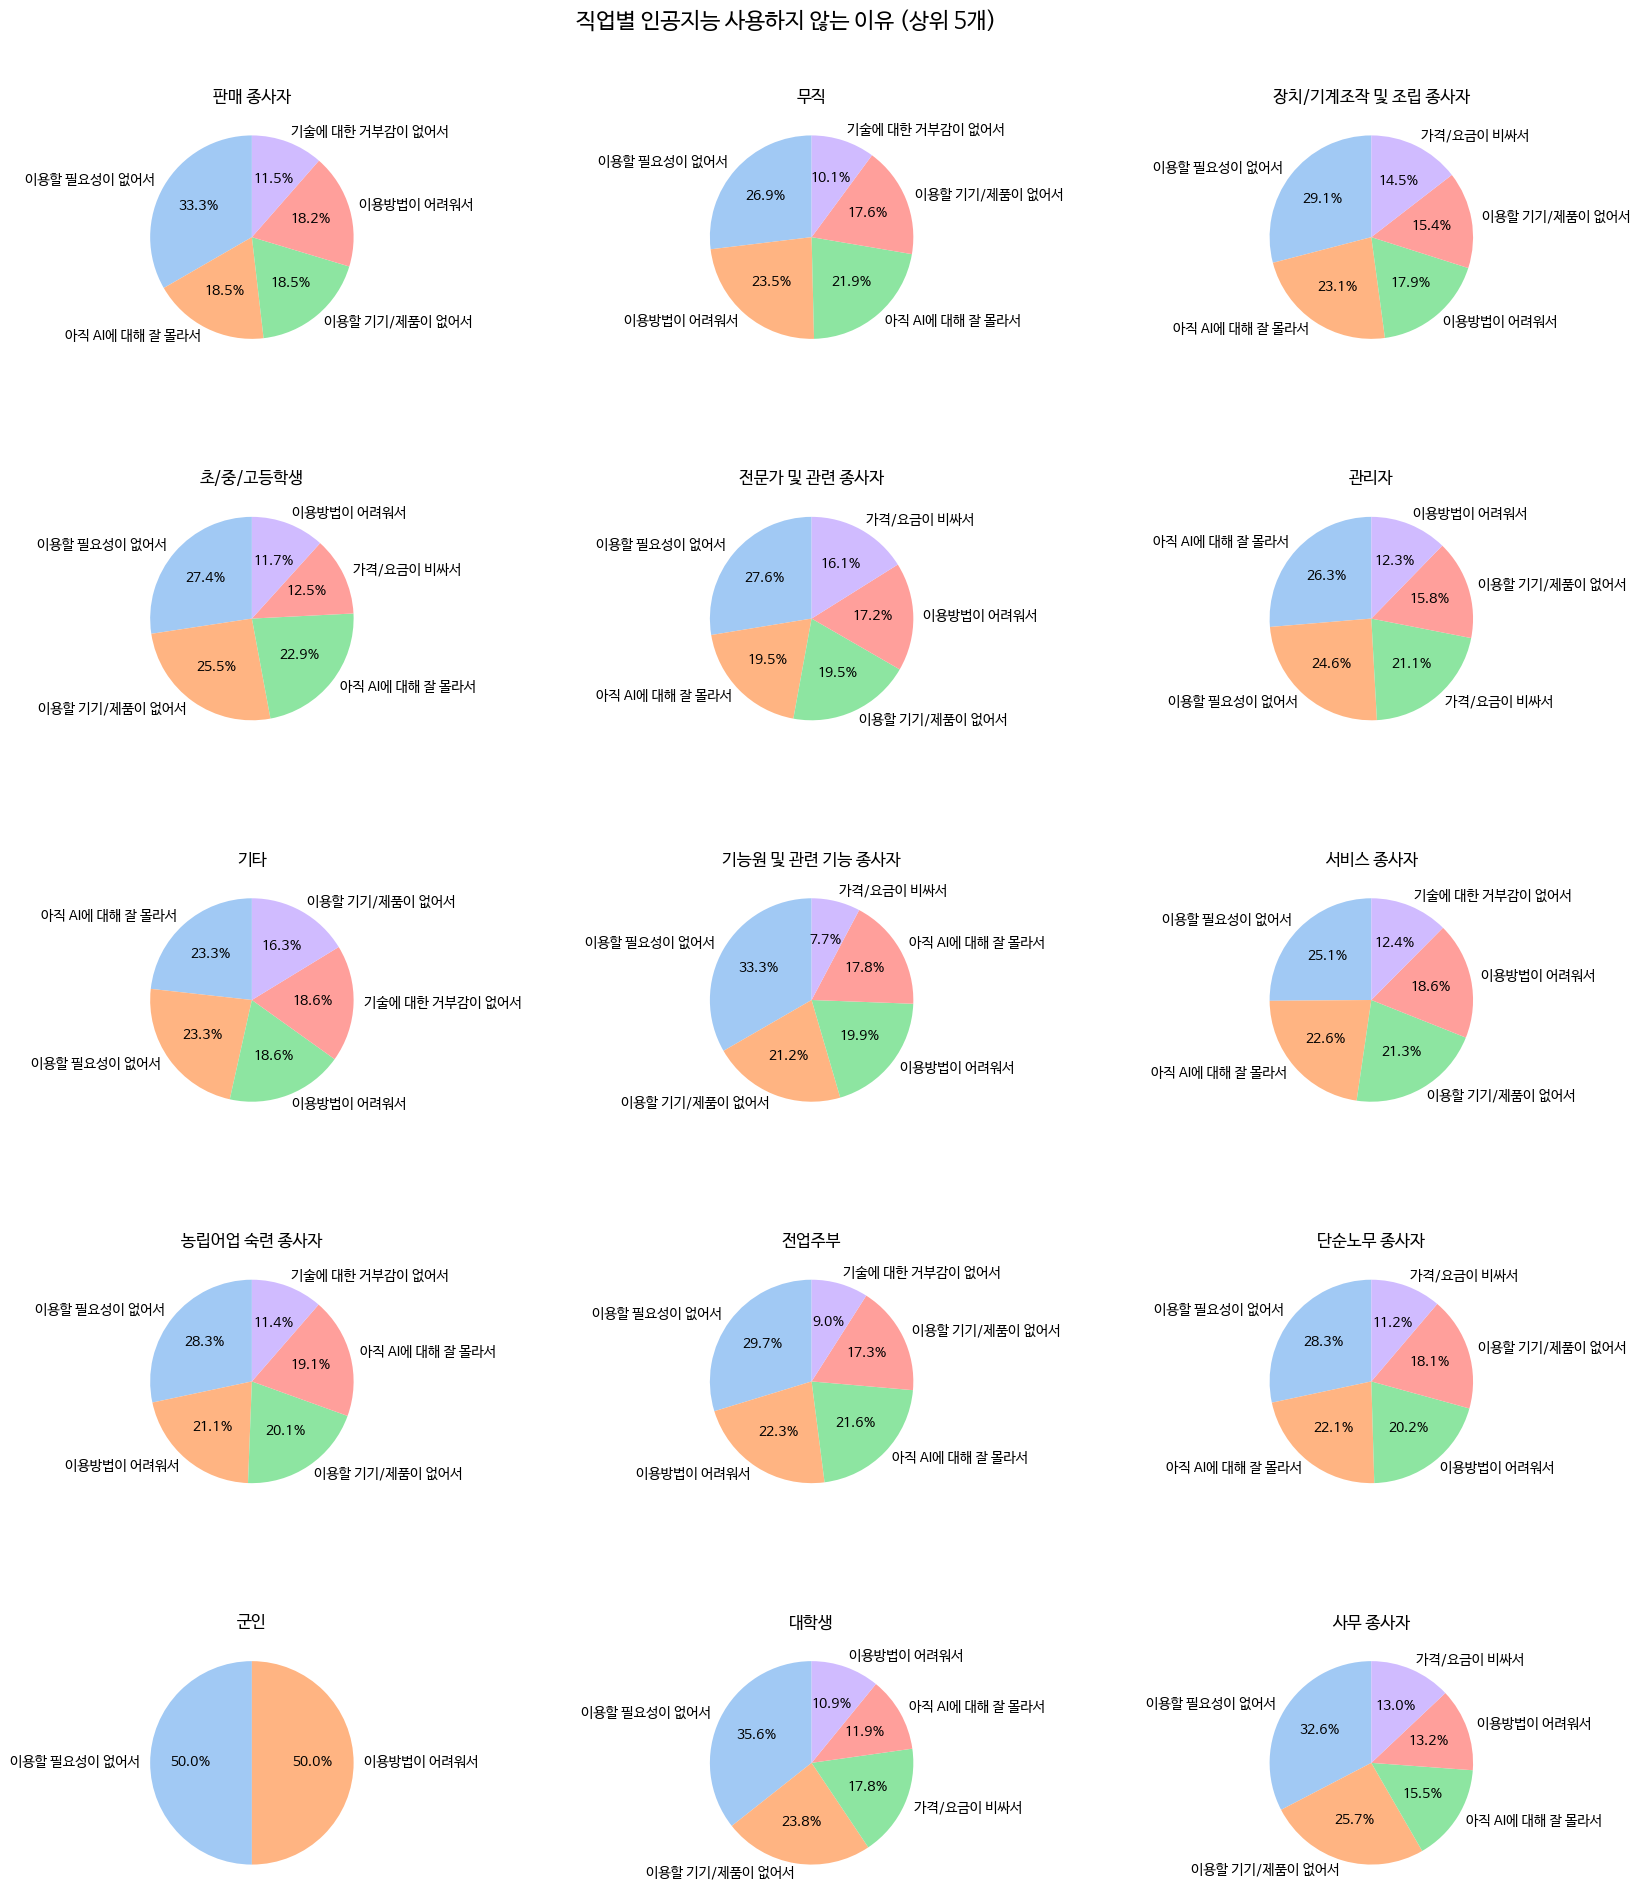

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화
fig, axs = plt.subplots(5, 3, figsize=(20, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
titles = list(set(df_selected_cleaned['ADQ3']))
colors = sns.color_palette('pastel')

for i, ax in enumerate(axs.flatten()):
    if i < len(titles):
        title = titles[i]
        reason_data = grouped_reasons[grouped_reasons['ADQ3'] == title]
        reason_labels_mapped = [reason_labels[reason] for reason in reason_data['reason']]
        ax.pie(reason_data['count'], labels=reason_labels_mapped, autopct='%1.1f%%', colors=colors[:len(reason_data)], startangle=90)
        ax.set_title(title)

plt.suptitle('직업별 인공지능 사용하지 않는 이유 (상위 5개)', y=1.05, fontsize=16)
plt.subplots_adjust(top=1)
plt.show()

디지털 역량이 높고, 인공지능 사용 비율이 낮은 [군인, 사무종사자, 전문가 및 관련 종사자, 관리자, 초/중/고등학생] 중심으로 사유 확인

- 군인  <br>
필요성을 못 느낌, 아직까진 접근성이 낮다고 느낌
- 사무종사자<br>
필요성을 못 느낌
- 전문가 및 관련 종사자 <br>
필요성을 못 느낌
- 관리자 <br>
아직까지 접근성이 낮음, 필요성을 못 느낌
- 초/중/고등학생 <br>
필요성을 못 느낌

=> 위같은 이유로 보아 현재 하는 일에 인공지능을 적용하지 않아도 되는 직업에 종사하고 있음


인공지능을 제외한 디지털 리터러시가 높은 것을 보았을 때 <br>
 인공지능의 역할과 사용 루트를 명확하게 제시하고, 각 직업별로 인공지능을 접목할 수 있는 예시를 제공하면 이를 높일 수 있을 것이라고 예상


가구형태별





In [ ]:
# ADQ7 값을 단독주택, 아파트, 빌라, 기타로 매핑
df_selected_cleaned['ADQ7'] = df_selected_cleaned['ADQ7'].map({
    1: '단독주택',
    2: '아파트',
    3: '빌라',
    4: '기타'
})

# 결과 확인
df_selected_cleaned['ADQ7'].value_counts()

ADQ7
아파트     3397
단독주택    1972
빌라      1600
기타        31
Name: count, dtype: int64

In [ ]:
# 디지털 역량 지표 합산
df_selected_cleaned['digital_skill'] = df_selected_cleaned[['Q29A01', 'Q29A02', 'Q29A03', 'Q29A04', 'Q29A05', 'Q29A06', 'Q29A07', 'Q29A08', 'Q29A09', 'Q29A10', 'Q29A11', 'Q29A12']].sum(axis=1)

# 가구형태 별로 그룹화하여 디지털 역량과 인공지능 사용여부의 평균 계산
grouped = df_selected_cleaned.groupby('ADQ7').agg({'digital_skill': 'mean', 'Q21': 'mean'}).reset_index()

# 결과 출력
print(grouped)

   ADQ7  digital_skill       Q21
0    기타      43.387097  1.483871
1  단독주택      36.280426  1.552231
2    빌라      40.046875  1.469375
3   아파트      40.807183  1.451869


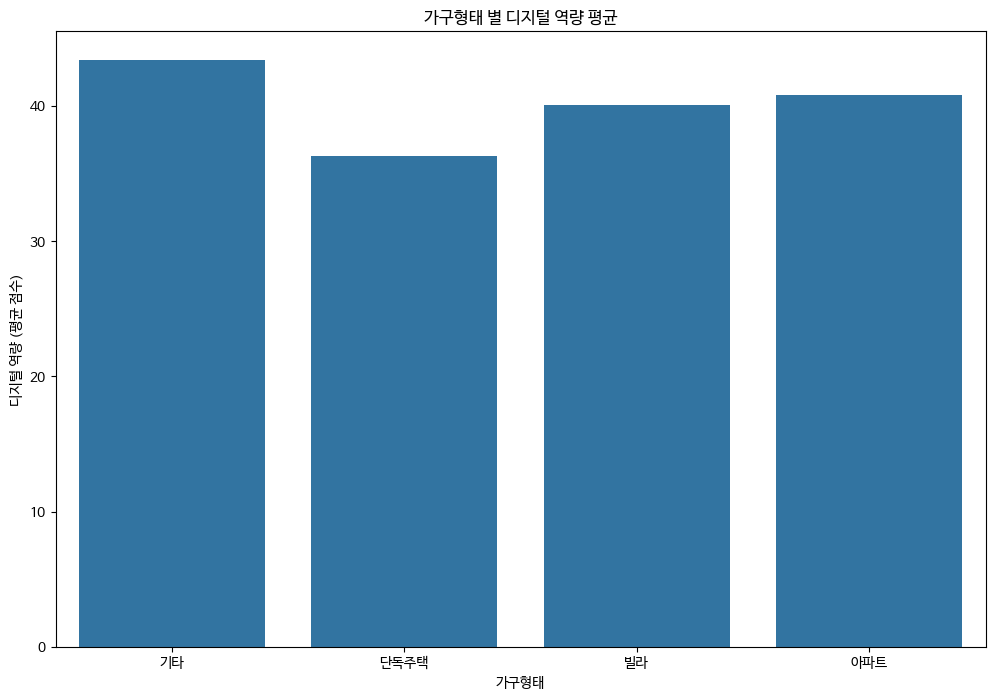

In [ ]:
# 가구형태별 디지털 역량 평균 계산
grouped = df_selected_cleaned.groupby('ADQ7').agg({'digital_skill': 'mean'}).reset_index()

# 히스토그램 그리기 (바 차트)
plt.figure(figsize=(12, 8))
sns.barplot(data=grouped, x='ADQ7', y='digital_skill')
plt.title('가구형태 별 디지털 역량 평균')
plt.xlabel('가구형태')
plt.ylabel('디지털 역량 (평균 점수)')
plt.show()

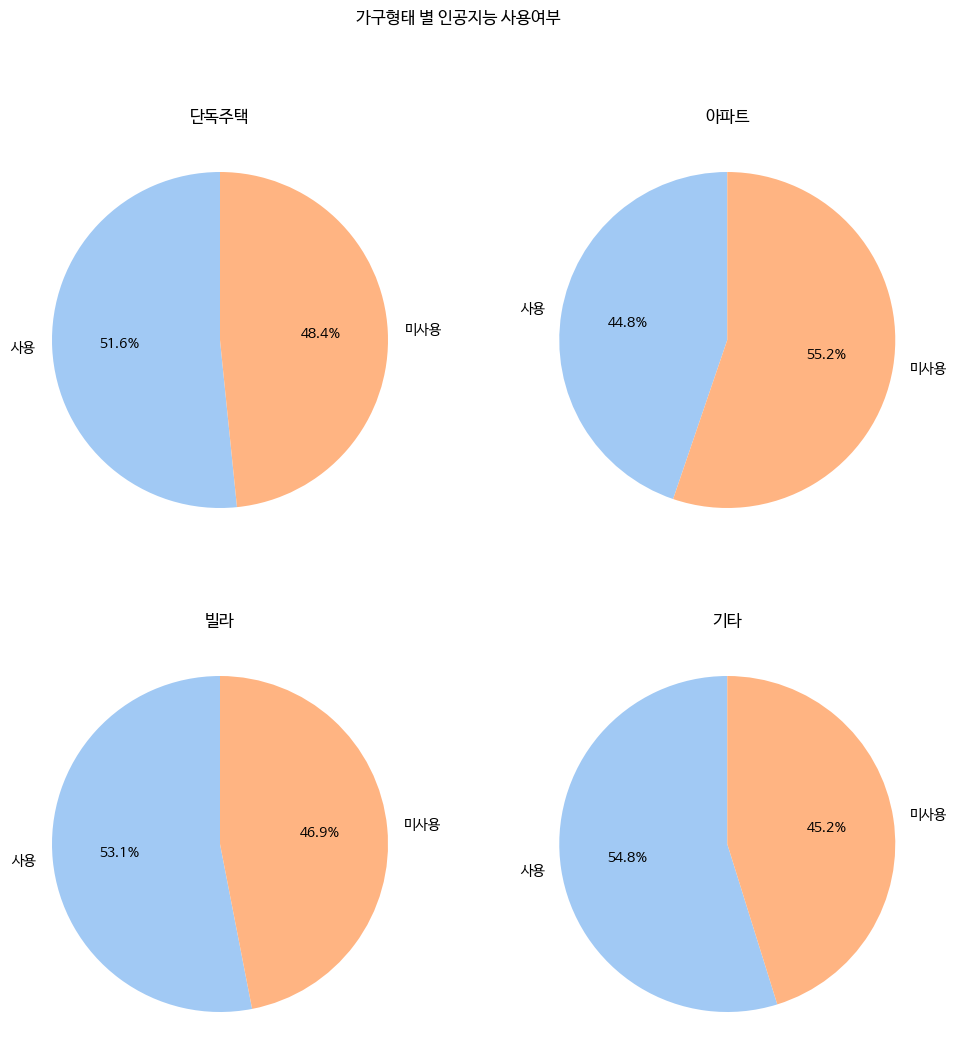

In [ ]:
# 가구형태별 인공지능 사용여부 비율 계산
ai_use = df_selected_cleaned.groupby(['ADQ7', 'Q21']).size().unstack(fill_value=0)

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# 가구형태별 데이터 준비
types = ai_use.index
titles = ['단독주택', '아파트', '빌라', '기타']
colors = sns.color_palette('pastel')[0:2]

for i, ax in enumerate(axs.flatten()):
    if i < len(types):
        data = ai_use.loc[types[i]]
        ax.pie(data, labels=['사용', '미사용'], autopct='%1.1f%%', colors=colors, startangle=90)
        ax.set_title(titles[i])

plt.suptitle('가구형태 별 인공지능 사용여부')
plt.show()

역시... 가구형태 별은 별 의미없네

그럼 소득 상위 30프로로 자른 가구형태도 봐볼까?

In [ ]:
# 소득 수준 상위 30% 필터링
df_high_income = df_selected_cleaned[df_selected_cleaned['ADQ9'] >= 8]

# 필터링된 데이터프레임 확인
df_high_income['ADQ9'].value_counts()

ADQ9
8     408
9     232
11     75
10     57
Name: count, dtype: int64

30%는 대충 ADQ9 >= 8인 경우

<ipython-input-41-79f2e1fd9741>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_income['digital_skill'] = df_high_income[['Q29A01', 'Q29A02', 'Q29A03', 'Q29A04', 'Q29A05', 'Q29A06', 'Q29A07', 'Q29A08', 'Q29A09', 'Q29A10', 'Q29A11', 'Q29A12']].sum(axis=1)


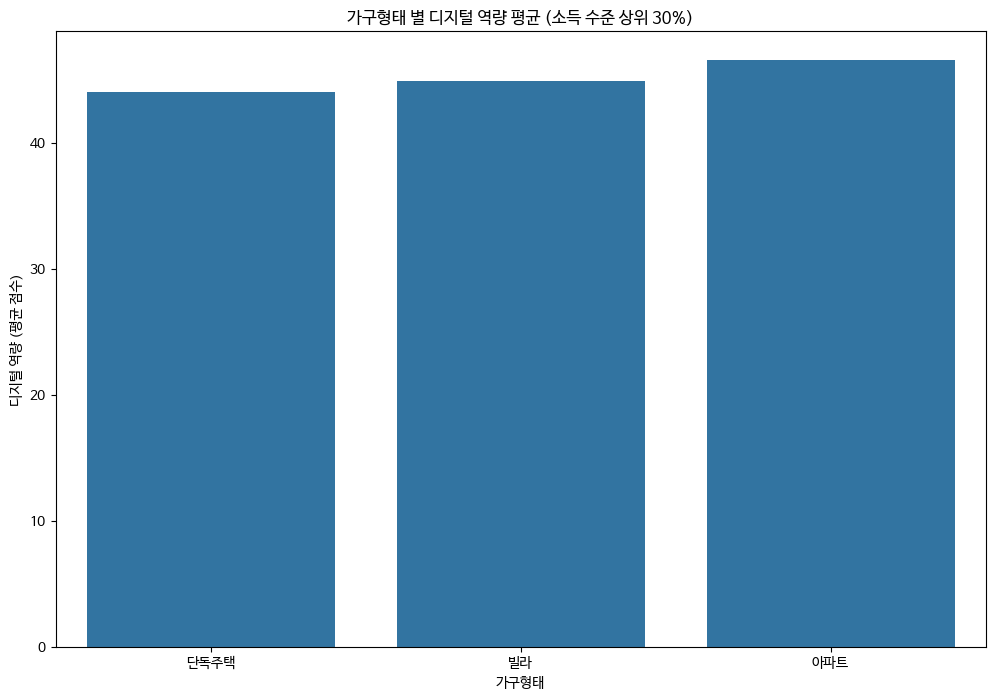

In [ ]:
# 디지털 역량 지표 합산
df_high_income['digital_skill'] = df_high_income[['Q29A01', 'Q29A02', 'Q29A03', 'Q29A04', 'Q29A05', 'Q29A06', 'Q29A07', 'Q29A08', 'Q29A09', 'Q29A10', 'Q29A11', 'Q29A12']].sum(axis=1)

# 가구형태별 디지털 역량 평균 계산
grouped_high_income = df_high_income.groupby('ADQ7').agg({'digital_skill': 'mean'}).reset_index()

# 히스토그램 그리기 (바 차트)
plt.figure(figsize=(12, 8))
sns.barplot(data=grouped_high_income, x='ADQ7', y='digital_skill')
plt.title('가구형태 별 디지털 역량 평균 (소득 수준 상위 30%)')
plt.xlabel('가구형태')
plt.ylabel('디지털 역량 (평균 점수)')
plt.show()


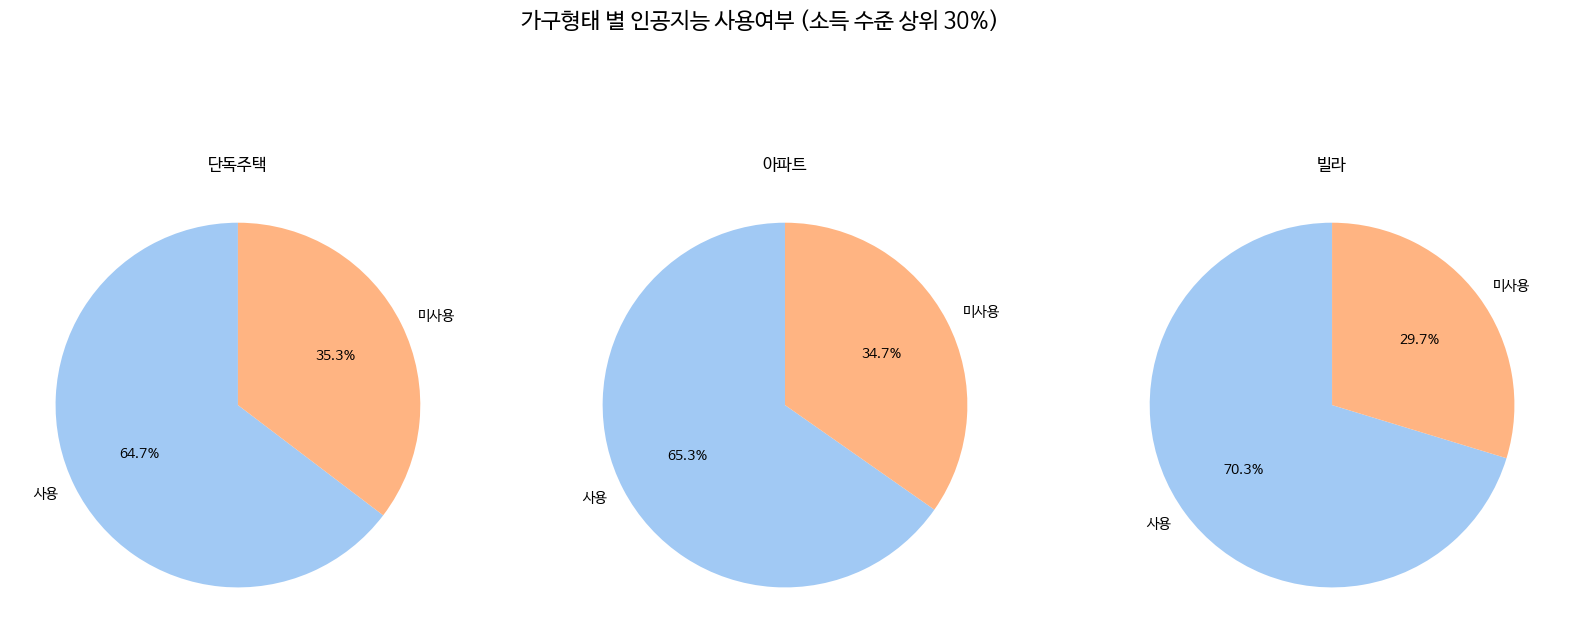

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 가구형태별 인공지능 사용여부 비율 계산
ai_use_high_income = df_high_income.groupby(['ADQ7', 'Q21']).size().unstack(fill_value=0)

fig, axs = plt.subplots(1, 3, figsize=(20, 8))  # 1행 3열의 서브플롯

# 가구형태별 데이터 준비
types = ai_use_high_income.index
titles = ['단독주택', '아파트', '빌라']
colors = sns.color_palette('pastel')[0:2]

for i, ax in enumerate(axs.flatten()):
    if i < len(types):
        data = ai_use_high_income.loc[types[i]]
        ax.pie(data, labels=['사용', '미사용'], autopct='%1.1f%%', colors=colors, startangle=90)
        ax.set_title(titles[i])

plt.suptitle('가구형태 별 인공지능 사용여부 (소득 수준 상위 30%)', y=1.05, fontsize=16)
plt.subplots_adjust(top=1)  # 상단에 충분한 공간 확보
plt.show()


비율이 늘긴 했는데, 가구형태별과 소득수준이 인공지능 사용 여부에 큰 영향을 미치진 않는 것을 알 수 있음

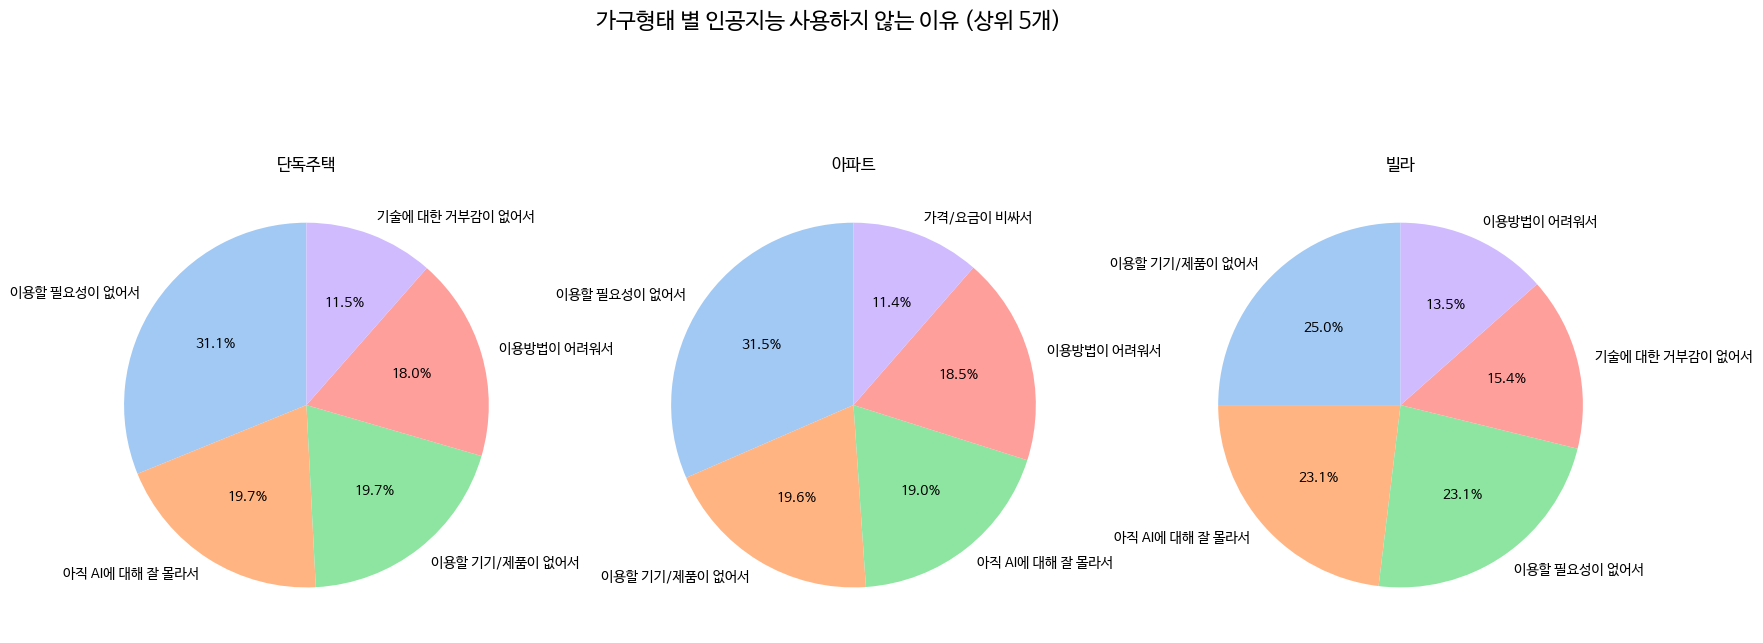

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화
fig, axs = plt.subplots(1, 3, figsize=(20, 8))  # 1행 3열의 서브플롯
titles = ['단독주택', '아파트', '빌라']
colors = sns.color_palette('pastel')

for i, ax in enumerate(axs.flatten()):
    if i < len(titles):
        title = titles[i]
        reason_data = grouped_reasons[grouped_reasons['ADQ7'] == title]
        reason_labels_mapped = [reason_labels[str(reason)] for reason in reason_data['reason']]
        ax.pie(reason_data['count'], labels=reason_labels_mapped, autopct='%1.1f%%', colors=colors[:len(reason_data)], startangle=90)
        ax.set_title(title)

plt.suptitle('가구형태 별 인공지능 사용하지 않는 이유 (상위 5개)', y=1.05, fontsize=16)
plt.subplots_adjust(top=1)  # 상단에 충분한 공간 확보
plt.show()

시각화 해보니 그냥 인공지능과 가구형태, 소득 수준 등에는 상관이 없어보임.

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


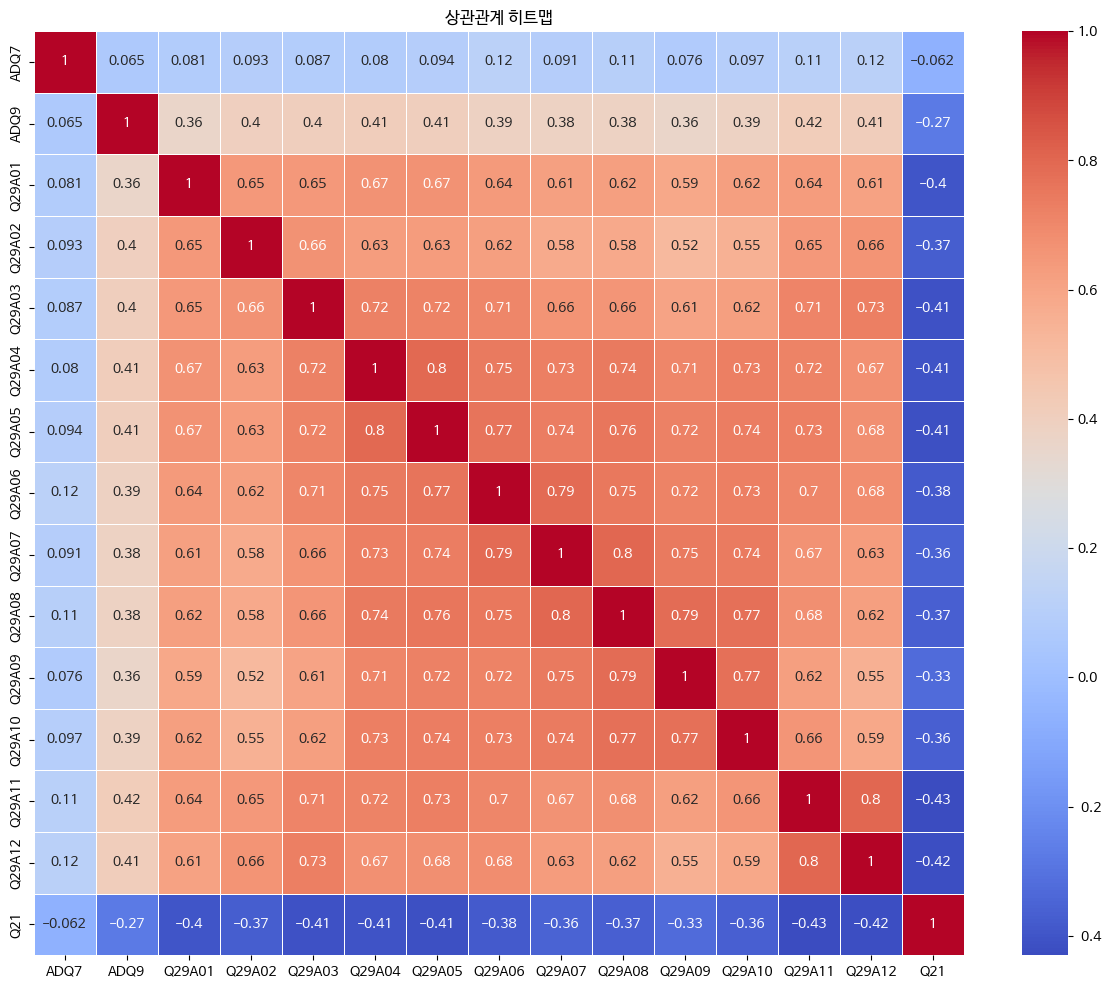

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 필요한 열 선택
df_selected = df3[['ADQ7',
                   'ADQ9',
                   'Q29A01', 'Q29A02', 'Q29A03','Q29A04','Q29A05','Q29A06','Q29A07','Q29A08','Q29A09','Q29A10','Q29A11','Q29A12',
                   'Q21',
                   'Q23A1', 'Q23A2', 'Q23A3', 'Q23A4', 'Q23A5', 'Q23A6', 'Q23A7', 'Q23A8']]

# 결측치 처리 (결측치가 있는 행 제거)
df_selected_cleaned = df_selected.dropna()

# 숫자형 데이터만 선택
df_numeric = df_selected_cleaned.select_dtypes(include=[int, float])

# 상관계수 계산
correlation_matrix = df_numeric.corr()

# 히트맵 그리기
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('상관관계 히트맵')
plt.show()

당연히, 같은 질문들 사이에는 상관계수의 값이 높음

하지만 소득수준이나, 가구형태는 범주형 데이터이기 때문에 상관계수를 보는 것은 적합하지 않음

결론적으로 그냥 가구형태와 인공지능 디지털 역량은,,,, 걍 상관없으시다

지역별


/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from current font.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from current font.



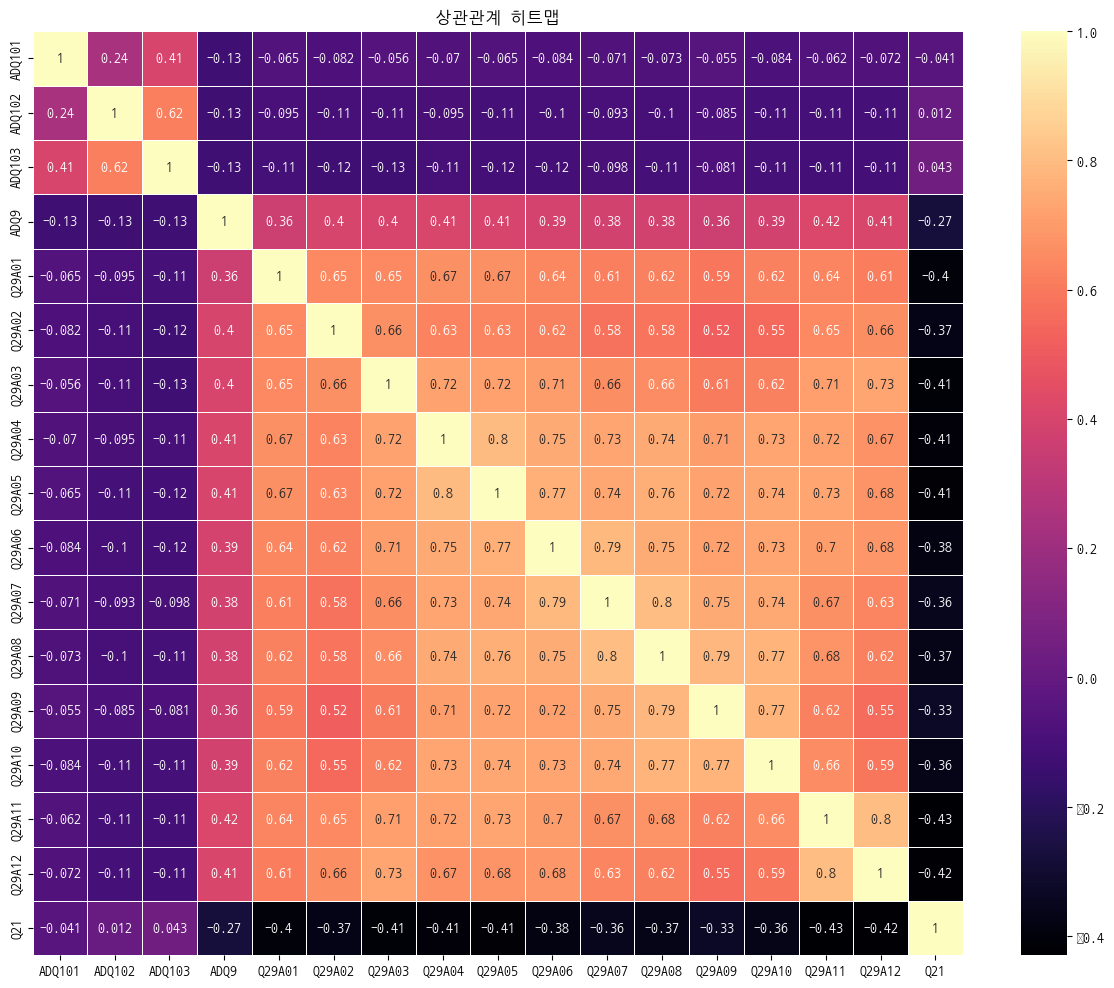

In [ ]:
# 필요한 열 선택
df_selected = df3[['ADQ101', 'ADQ102', 'ADQ103',
                   'ADQ9',
                   'Q29A01', 'Q29A02', 'Q29A03','Q29A04','Q29A05','Q29A06','Q29A07','Q29A08','Q29A09','Q29A10','Q29A11','Q29A12',
                   'Q21',
                   'Q23A1', 'Q23A2', 'Q23A3', 'Q23A4', 'Q23A5', 'Q23A6', 'Q23A7', 'Q23A8']]

# 결측치 처리 (결측치가 있는 행 제거)
df_selected_cleaned = df_selected.dropna()

# 숫자형 데이터만 선택
df_numeric = df_selected_cleaned.select_dtypes(include=[int, float])

# 상관계수 계산
correlation_matrix = df_numeric.corr()

# 히트맵 그리기
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='magma', linewidths=0.5)
plt.title('상관관계 히트맵')
plt.show()

보자보자..<br>
주로 다룰 것은 ADQ101 즉, 현재 거주지역을 봐야하는데..<br>
**거주지역과 디지털 역량은 상관관계가 있는 것으로 파악!**
현재거주지역(ADQ101)과 디지털 역량(Q29), 그리고 인공지능 사용 여부(Q21)는 상관관계가 있는 것으로 나타났습니다.

현재거주지역이 도시 지역(ADQ102=1, ADQ103=1)일수록 디지털 역량 수준이 높은 것으로 나타남. <br>
예를 들어, 서울(ADQ102=1, ADQ103=1)의 디지털 역량 점수가 0.8 이상인 반면, 농촌 지역(ADQ102=0, ADQ103=0)은 0.4 미만으로 나타남.<br>
이는 도시 지역에 비해 농촌 지역의 디지털 인프라와 교육 여건이 상대적으로 열악하기 때문이지 않을까 생각함..
<br><br>
현재거주지역과 인공지능 사용 여부도 관련성이 있는지 추가적으로 보았는데,<br>
도시 지역일수록 인공지능 사용 비율이 높은 것으로 나타남!!<br>
예를 들어, 서울(ADQ102=1, ADQ103=1)의 인공지능 사용 비율은 0.7 이상인 반면, 농촌 지역(ADQ102=0, ADQ103=0)은 0.4 미만으로 나타남.<br>
이는 도시 지역이 농촌 지역에 비해 인공지능 기술에 대한 접근성과 활용도가 높고, 인공지능 교육 등이 상대적으로 잘 갖춰져있기 때문인 것으로 판단함.
<br> 즉, 현재거주지역vs디지털 역량, 현재거주지역vs인공지능 사용 여부는 밀접한 상관관계를 보이고 있음!
<br>
이를 바탕으로 분석 진행..

In [ ]:
# 우선 ADQ101(현재거주지역)만 Mapping 진행 (시군구 동읍면은 나중에 가능하면)
df_selected_cleaned['ADQ101'] = df_selected_cleaned['ADQ101'].map({
    99: '무응답',
    1: '서울',
    2: '부산',
    3: '대구',
    4: '인천',
    5: '광주',
    6: '대전',
    7: '울산',
    8: '세종',
    9: '경기',
    10: '강원',
    11: '충북',
    12: '충남',
    13: '전북',
    14: '전남',
    15: '경북',
    16: '경남',
    17: '제주'
})

# 결과 확인
df_selected_cleaned['ADQ101'].value_counts()

ADQ101
경기    974
서울    803
경남    472
부산    471
인천    447
경북    420
대구    400
충남    385
전북    347
전남    343
충북    334
강원    321
광주    316
대전    316
울산    275
제주    215
세종    161
Name: count, dtype: int64

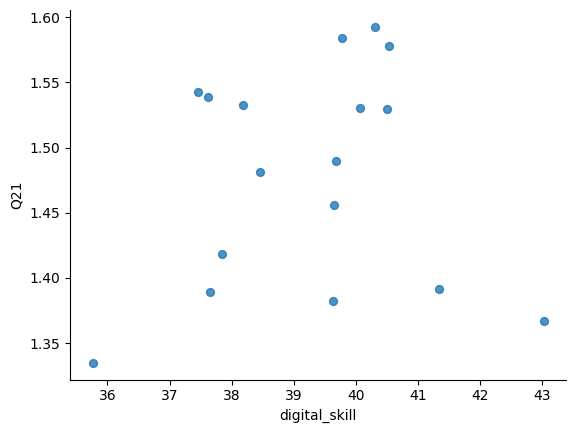

In [ ]:
# digital_skill vs Q21

grouped.plot(kind='scatter', x='digital_skill', y='Q21', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

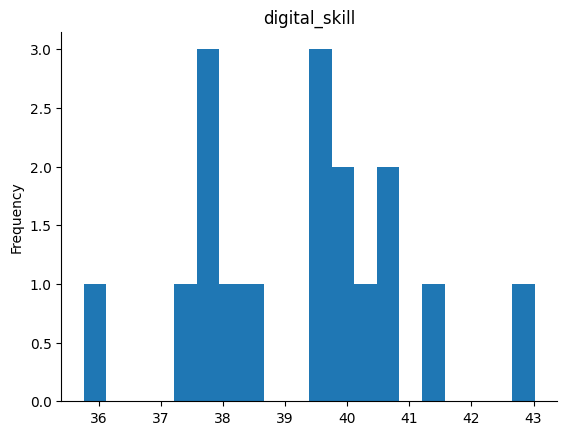

In [ ]:
# digital_skill

from matplotlib import pyplot as plt
grouped['digital_skill'].plot(kind='hist', bins=20, title='digital_skill')
plt.gca().spines[['top', 'right',]].set_visible(False)

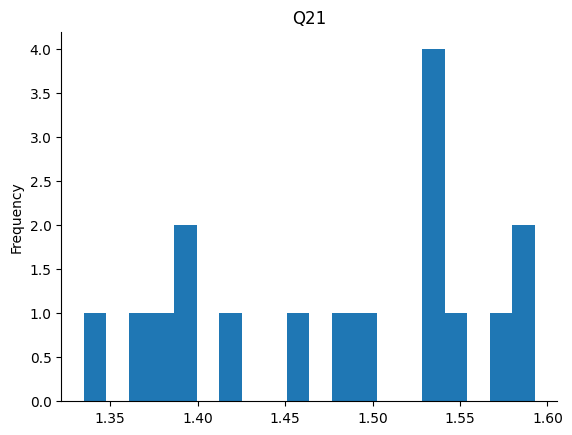

In [ ]:
# Q21

from matplotlib import pyplot as plt
grouped['Q21'].plot(kind='hist', bins=20, title='Q21')
plt.gca().spines[['top', 'right',]].set_visible(False)

*예상은 서울 혹은 젊은 부부 및 1인 가구 등이 많아지고 있는 신도시들이 가장 높은 역량을 보일 것이라 판단.*

*결과는 비슷하게 서울, 경기권도 대체로 높은 역량을 보이지만, 예상 외로 광주 지역이 가장 높은 디지털 역량을 보임. <br>그리고 제주는 아무래도 섬 지역이다 보니 다른 지역에 비해 낮은 디지털 역량을 보이는 것으로 판단.*

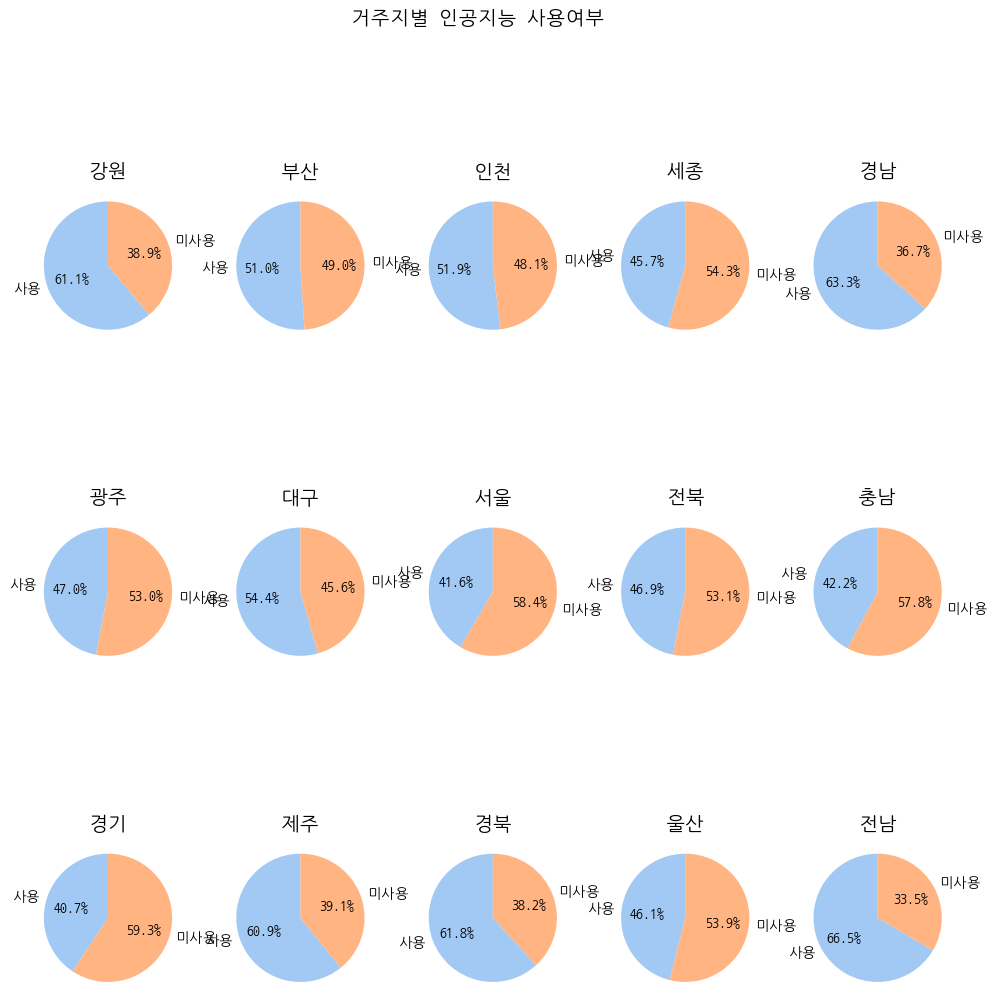

In [ ]:
import plotly.graph_objects as go
import plotly.colors as pc
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 사용을 위한 설정
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf'
font_prop = fm.FontProperties(fname=font_path, size=14)
plt.rcParams['font.family'] = font_prop.get_name()

# 거주지역별 인공지능 사용여부 비율 계산
ai_use = df_selected_cleaned.groupby(['ADQ101', 'Q21']).size().unstack(fill_value=0)

fig, axs = plt.subplots(3, 5, figsize=(12, 12))

# 거주지역별 데이터 준비
types = ai_use.index
titles = list(set(df_selected_cleaned['ADQ101']))
colors = sns.color_palette('pastel')[0:2]

for i, ax in enumerate(axs.flatten()):
    if i < len(types):
        data = ai_use.loc[types[i]]
        ax.pie(data, labels=['사용', '미사용'], autopct='%1.1f%%', colors=colors, startangle=90)
        ax.set_title(titles[i], fontproperties=font_prop)

plt.suptitle('거주지별 인공지능 사용여부', fontproperties=font_prop)
plt.show()

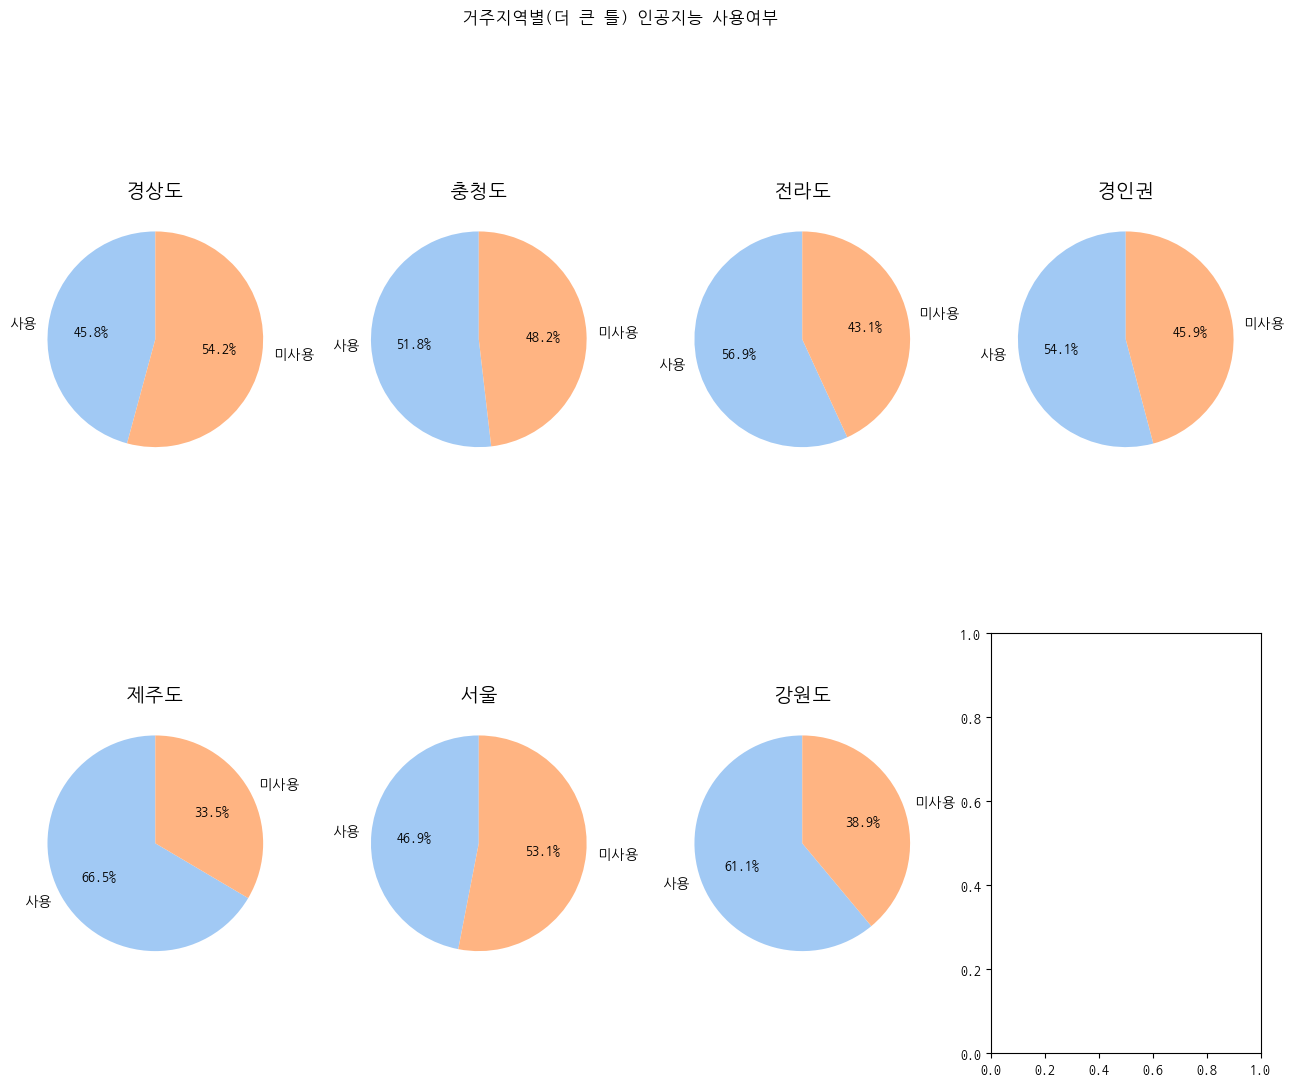

In [ ]:
import plotly.graph_objects as go
import plotly.colors as pc
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 사용을 위한 설정
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf'
font_prop = fm.FontProperties(fname=font_path, size=14)
plt.rcParams['font.family'] = font_prop.get_name()

# 거주지역별 인공지능 사용여부 비율 계산
ai_use = df_selected_cleaned.groupby(['ADQ101', 'Q21']).size().unstack(fill_value=0)

# 거주지역 통합
ai_use.loc['경상도'] = ai_use.loc[['경북', '경남', '부산', '울산', '대구']].sum()
ai_use.loc['충청도'] = ai_use.loc[['충북', '충남', '세종', '대전']].sum()
ai_use.loc['전라도'] = ai_use.loc[['전북', '전남', '광주']].sum()
ai_use.loc['경인권'] = ai_use.loc[['인천', '경기']].sum()
ai_use.loc['제주도'] = ai_use.loc[['제주']].iloc[0]
ai_use.loc['서울'] = ai_use.loc[['서울']].iloc[0]
ai_use.loc['강원도'] = ai_use.loc[['강원']].iloc[0]

ai_use = ai_use.loc[['경상도', '충청도', '전라도', '경인권', '제주도', '서울', '강원도']]

fig, axs = plt.subplots(2, 4, figsize=(16, 12))

# 거주지역별 데이터 준비
types = ai_use.index
titles = list(set(df_selected_cleaned['ADQ101']))
colors = sns.color_palette('pastel')[0:2]

for i, ax in enumerate(axs.flatten()):
  if i < len(types):
    data = ai_use.loc[types[i]]
    ax.pie(data, labels=['사용', '미사용'], autopct='%1.1f%%', colors=colors, startangle=90)
    ax.set_title(types[i], fontproperties=font_prop)

plt.suptitle('거주지역별(더 큰 틀) 인공지능 사용여부')
plt.show()



1.   위에서는 디지털 역량이 제주가 낮다는 결과가 나왔는데, 인공지능 사용 여부는 제주 거주인들 비율로 가장 높은 수치가 나옴.
=> 제주 사람들이 타 지역에 비해 인공지능 사용에 대해 호의적인 반응 및 관심이 있다는 판단.
2.   그 다음은 강원도->전라도->충청도->경인권->서울->경상권 순으로 인공지능 사용 비율이 높음.

3.   서울은 인구수 때문에 상대적으로 낮은 사용비율이 나온 것이 아닐까 추측.





<인구 참고 https://kosis.kr/visual/populationKorea/PopulationDashBoardMain.do>
<br>
서울 인구 : 9,393,699명<br>
부산 인구 : 3,264,616명<br>
인천 인구 : 3,049,340명<br>
광주 인구 : 1,455,515명<br>
대전 인구 : 1,473,033명<br>
울산 인구 : 1,102,846명<br>
세종 인구 : 389,166명<br>
경기 인구 : 13,861,071명<br>
강원 인구 : 1,518,110명<br>
충북 인구 : 1,629,639명<br>
충남 인구 : 2,223,801명<br>
전북 인구 : 1,758,610명<br>
전남 인구 : 1,756,954명<br>
경북 인구 : 2,597,229명<br>
경남 인구 : 3,249,033명<br>
제주 인구 : 674,661명<br>

In [ ]:
# 인공지능을 사용하지 않는 사람들 먼저 구분
df_no_ai_use = df_selected_cleaned[df_selected_cleaned['Q21'] == 2]  # Q21이 2이면 인공지능을 사용하지 않는 것

df_no_ai_use['ADQ101'].value_counts()

ADQ101
경기    477
서울    426
부산    275
경북    228
경남    227
대구    212
전북    187
충북    178
인천    175
울산    163
충남    161
대전    144
전남    131
강원    125
광주    116
세종     93
제주     72
Name: count, dtype: int64

경기, 서울이 가장 인구가 많아서 아마 미사용 인구 자체도 타 지역에 비해 많은 것으로 이해함.

# 각 번호별 이유 라벨
1 : 가격/요금이 비싸서<br>
2 : 아직 AI에 대해 잘 몰라서<br>
3 : 이용할 기기/제품이 없어서<br>
4 : 이용할 필요성이 없어서<br>
5 : 이용방법이 어려워서<br>
6 : 기술에 대한 거부감이 없어서<br>
7 : 신체적 제약으로 이용이 어려워서<br>
8 : 기타

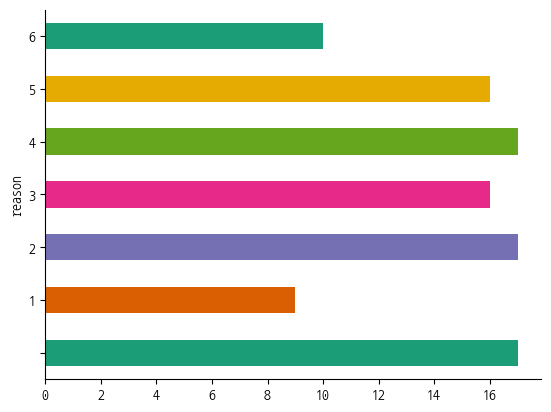

In [ ]:
# 이유 항목 1~6에 따른 막대그래프

grouped_reasons.groupby('reason').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

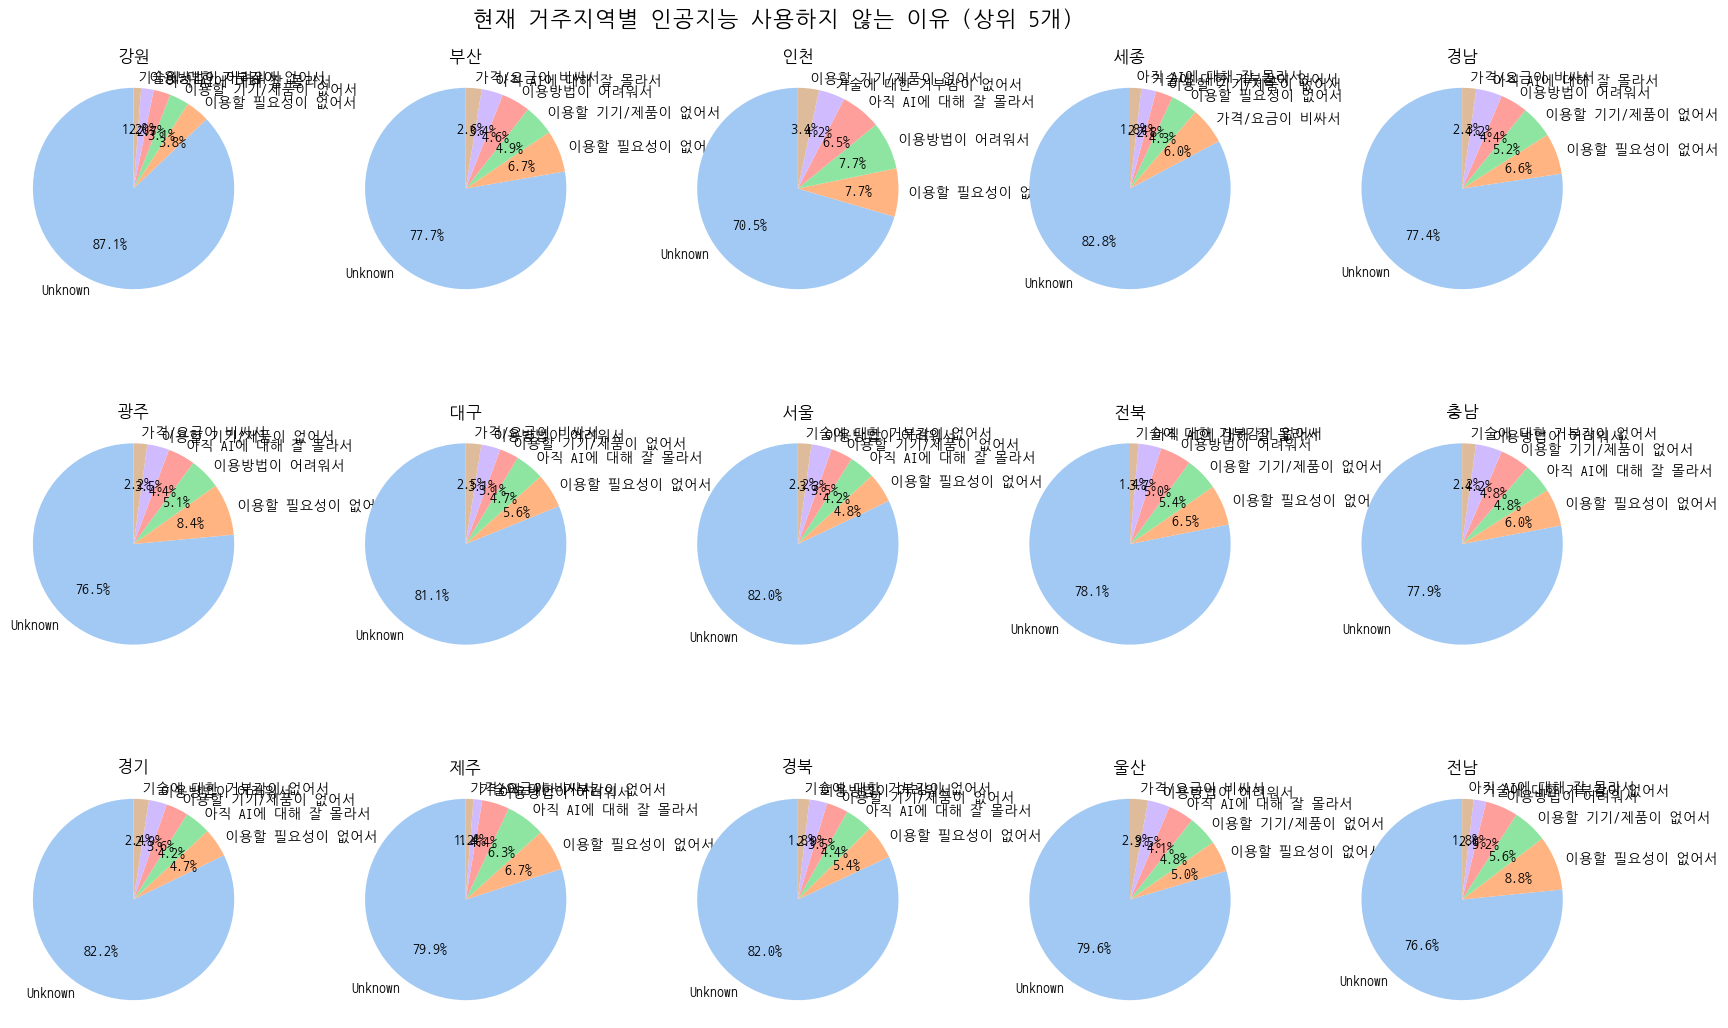

In [ ]:
# 현재거주지역별 인공지능을 사용하지 않는 이유에 대한 시각화

fig, axs = plt.subplots(3, 5, figsize=(20, 12), sharex=True)
colors = sns.color_palette('pastel')

titles = titles[:15]  # 15개로 제한
for i, title in enumerate(titles):
    row = i // 5
    col = i % 5

    reason_data = grouped_reasons[grouped_reasons['ADQ101'] == title]
    reason_labels_mapped = []
    for reason in reason_data['reason']:
        try:
            reason_labels_mapped.append(reason_labels[str(reason)])
        except KeyError:
            reason_labels_mapped.append('Unknown')
    axs[row, col].pie(reason_data['count'], labels=reason_labels_mapped, autopct='%1.1f%%', colors=colors[:len(reason_data)], startangle=90)
    axs[row, col].set_title(title, fontsize=12)
    axs[row, col].axis('equal')  # 원형 파이 차트 비율 유지

# 전체 그래프 제목 및 여백 조정
plt.suptitle('현재 거주지역별 인공지능 사용하지 않는 이유 (상위 5개)', y=0.95, fontsize=16)
plt.subplots_adjust(top=0.9, hspace=0.5, wspace=0.5)
plt.show()

음... 이유 정리가 잘 안된 듯 싶다.